## Perform PCA on BBB Data
**Ayush Noori**

First, I load the relevant libraries.

In [1]:
# import base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # inline plots
%matplotlib inline

# import torch
import torch

# import TDC
from tdc.single_pred import ADME
from tdc.chem_utils import MolConvert

c:\Users\unity\.conda\envs\gnn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and Stratify Data

Next, I load the dataset retrieved from the [Therapeutics Data Commons (TDC)](https://tdcommons.ai/single_pred_tasks/adme/#bbb-blood-brain-barrier-martins-et-al) and examine basic parameters.

In [2]:
data = ADME(name = 'BBB_Martins').get_data()
data.head()

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,Propanolol,CC(C)NCC(O)COc1cccc2ccccc12.[Cl],1
1,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1
2,40730,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1
3,24,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1
4,cloxacillin,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1


Now, define a converter to convert molecules from SMILES structures to RDKit2D format. See documentation [here](https://tdcommons.ai/functions/data_process/#molecule-conversion). 

In [37]:
# define converter
converter = MolConvert(src = "SMILES", dst = "MACCS")

# convert to fingerprint
fps = pd.DataFrame([converter(x) for x in data['Drug']])
fps.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Now, perform PCA.

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

fps_norm = StandardScaler().fit_transform(fps)
# fps_norm = fps
pca = PCA(n_components = 4)
PCs = pca.fit_transform(fps_norm)

PCs_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2', 'PC3', 'PC4'])

Combine PCA data with label.

In [46]:
# combine with label
df = pd.concat([PCs_df, data["Y"]], axis = 1)
df["Y"] = ["Permeable" if x == 1 else "Non-Permeable" for x in df["Y"]]
print("Permeable:", sum(df['Y'] == "Permeable"))
print("Non-Permeable:", sum(df['Y'] == "Non-Permeable"))

Permeable: 1551
Non-Permeable: 479


Plot scree plot with percent variance explained by each principal component.

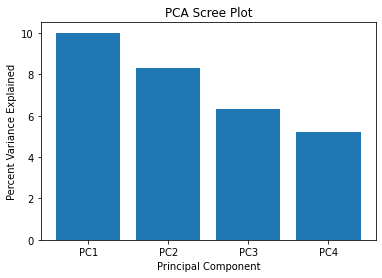

In [49]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals = 2)
columns = ['PC1', 'PC2', 'PC3', 'PC4']
plt.bar(x = range(1,5), height = percent_variance, tick_label = columns)
plt.ylabel('Percent Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

Print percent variance explained.

In [50]:
print("PCA Explained Variance:", percent_variance)

PCA Explained Variance: [10.01  8.29  6.32  5.21]


Plot principal components.

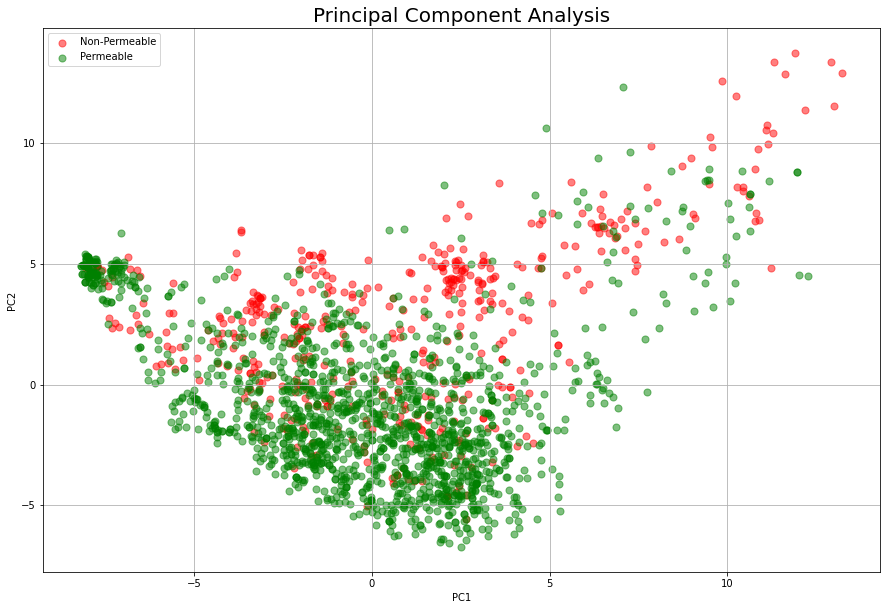

In [48]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.grid()

ax.set_title('Principal Component Analysis', fontsize = 20)

targets = ["Non-Permeable", "Permeable"]

colors = ['r', 'g']

for target, color in zip(targets, colors):
    indicesToKeep = df['Y'] == target
    ax.scatter(df.loc[indicesToKeep, 'PC1'], df.loc[indicesToKeep, 'PC2'], c = color, s = 50, alpha = 0.5)
    
ax.legend(targets)